In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# 데이터 준비
df = pd.read_csv("data/bsmax_0_1", sep='\t')
print(df.head())
print(df.shape)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.FloatTensor(sequences), torch.FloatTensor(targets)

seq_length = 10  # 시퀀스 길이
data = df.values

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)
sequences, targets = create_sequences(data_normalized, seq_length)
print(sequences.shape, targets.shape)

train_sequences, test_sequences, train_targets, test_targets = train_test_split(
    sequences, targets, test_size=0.2, shuffle=True)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        y1 = self.tcn(x)
        o = self.linear(y1[:, :, -1])
        return o

input_size = train_sequences.shape[2]
output_size = train_targets.shape[1]
num_channels = [25] * 4
kernel_size = 7
dropout = 0.0

model = TCN(input_size, output_size, num_channels, kernel_size, dropout)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 학습률을 낮게 설정

# 학습
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_sequences.permute(0, 2, 1))  # TCN은 (batch, channel, seq_len) 형식을 기대함
    loss = criterion(outputs, train_targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_sequences.permute(0, 2, 1))
            test_loss = criterion(test_outputs, test_targets)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

model.eval()
with torch.no_grad():
    test_outputs = model(test_sequences.permute(0, 2, 1))
    test_loss = criterion(test_outputs, test_targets)
    print(f'Test Loss: {test_loss.item():.4f}')

# 예측 결과 시각화 및 저장
predicted = test_outputs.cpu().numpy()
actual = test_targets.cpu().numpy()

# headers에 맞게 데이터를 정규화 해제합니다.
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)
header = "ymd	init	rtn	avg	dev	bkmax	skmax	bomega	somega	bpri	bfor	bmom	bc	bpmax	bmax	bmomn	bcn	bpmaxn	bmaxn	spri	sfor	smom	sc	spmax	smax	smomn	scn	spmaxn	smaxn".split("\t")



     ymd    init   rtn     avg   dev  bkmax  skmax  bomega  somega   bpri  \
0  90323  192333  -500  192670  1452     12     14  -0.002   0.002 -0.277   
1  90324  192562 -4848  187788  1542      5      6   0.020   0.039 -0.385   
2  90325  188812 -2098  187049   574      4      7   0.001   0.001 -0.179   
3  90326  186556   944  187753   517      6      8   0.001  -0.001 -0.323   
4  90327  187794 -2982  185802   756     10     10  -0.001   0.001 -0.402   

   ...   spri      sfor      smom      sc    spmax    smax   smomn    scn  \
0  ... -0.267  3284.428   412.228   9.682  315.230  23.000  10.655  0.052   
1  ... -0.404  6665.924  1028.882   8.776  721.892  30.500  10.915  0.032   
2  ... -0.228  2723.411   315.232  11.061  151.065  19.429   9.821  0.065   
3  ... -0.205  1627.165   208.041   8.732  216.675  23.125   8.048  0.056   
4  ... -0.129  2233.416   208.066  11.381   91.132  22.300   7.397  0.073   

     spmaxn  smaxn  
0  1293.851  0.000  
1  1239.855  6.333  
2   945.091

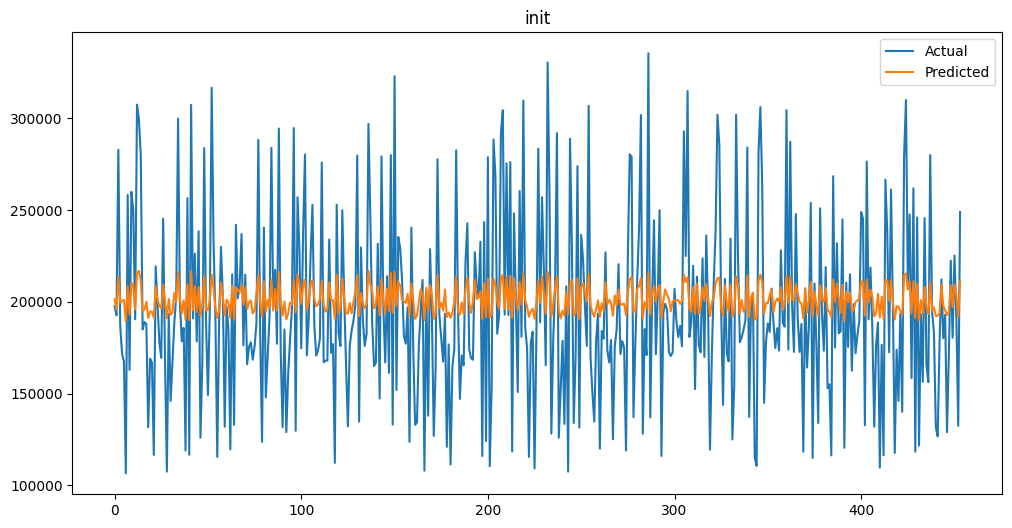

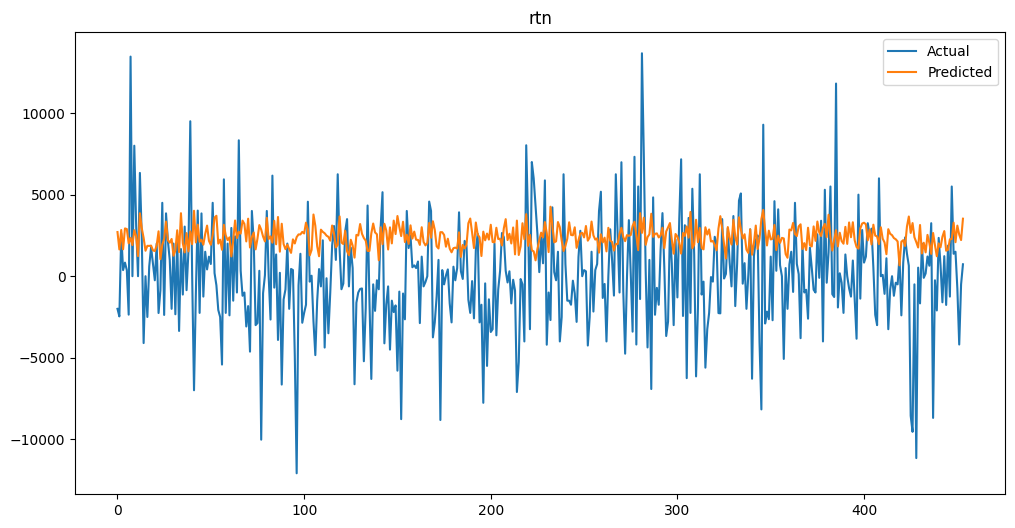

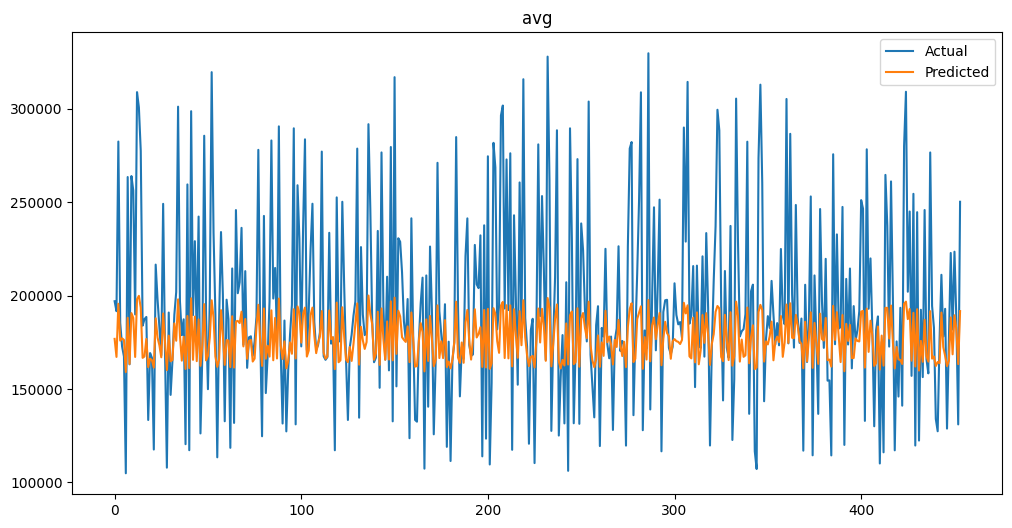

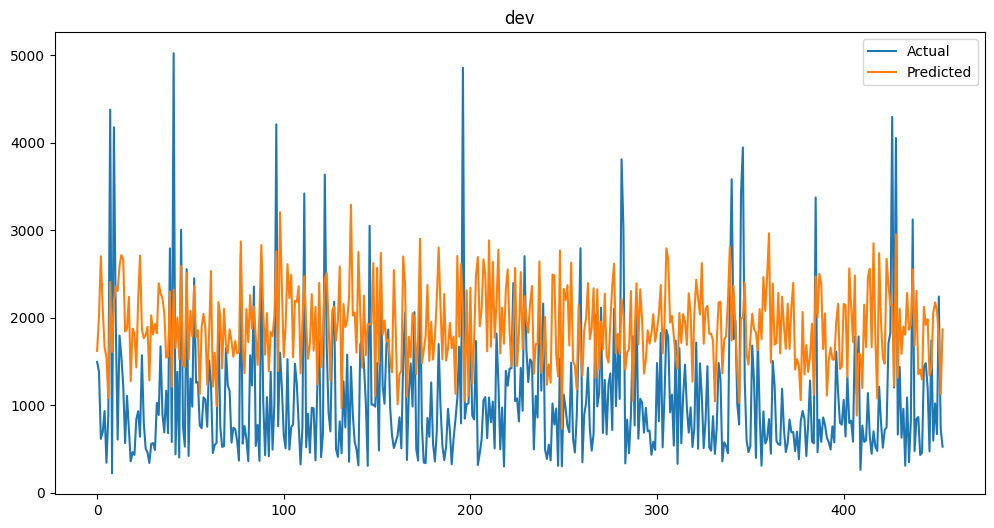

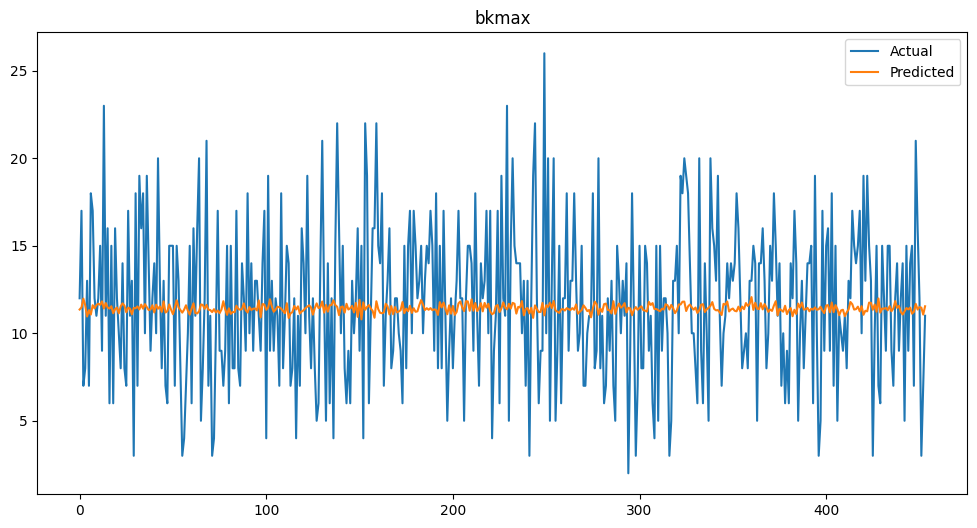

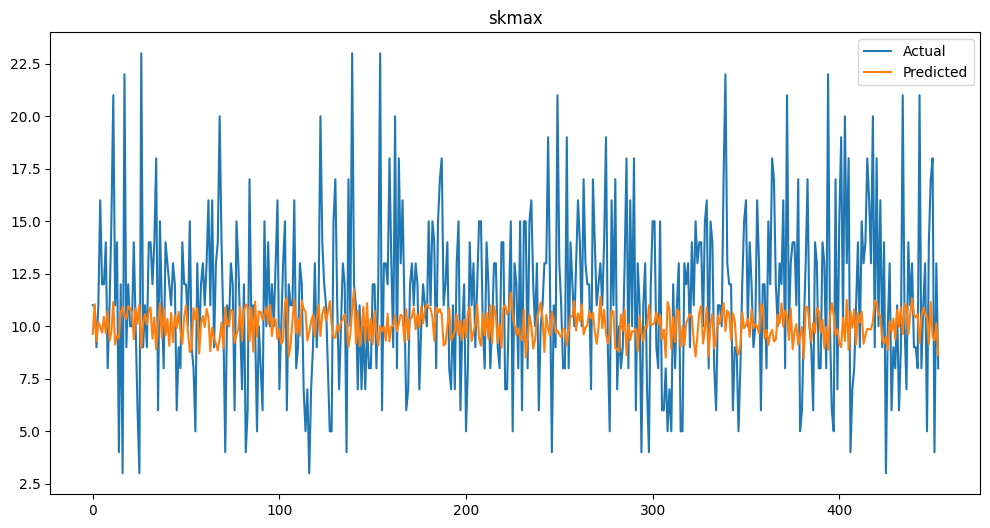

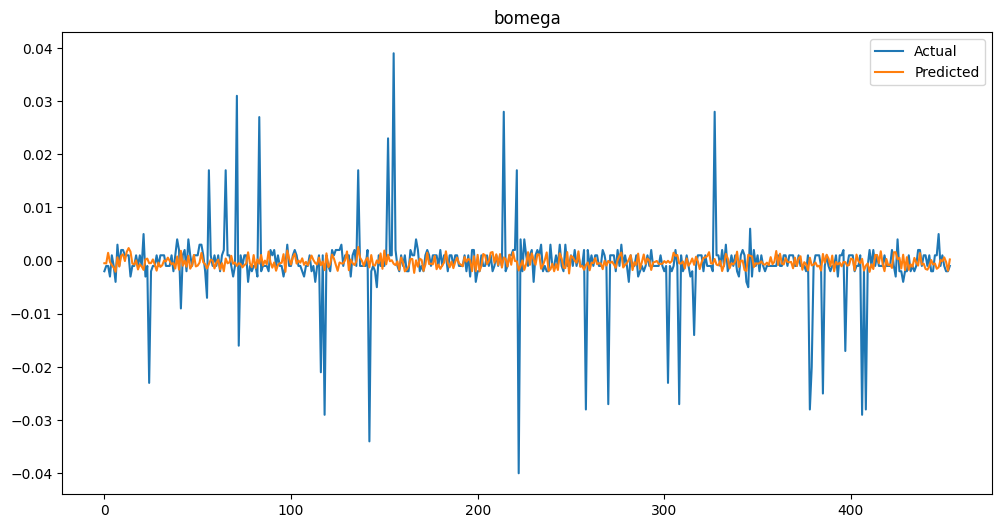

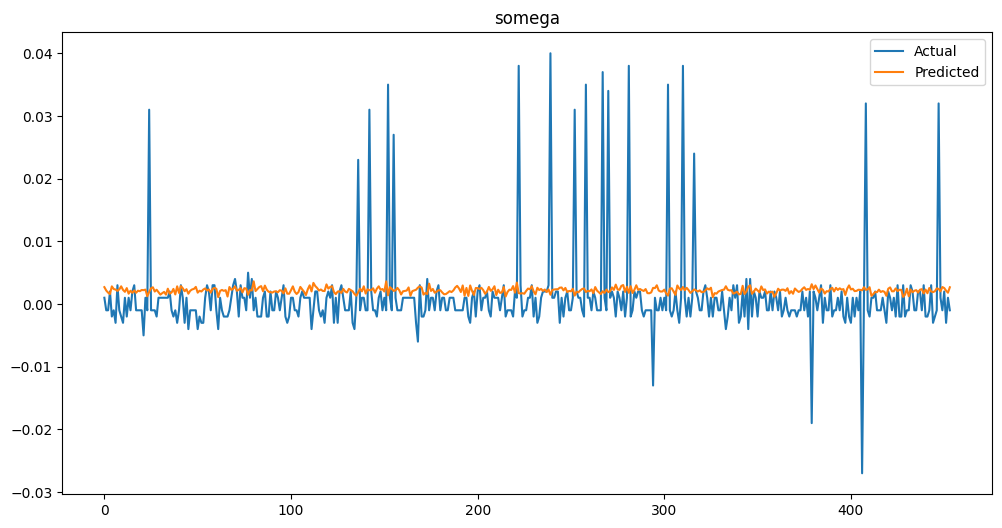

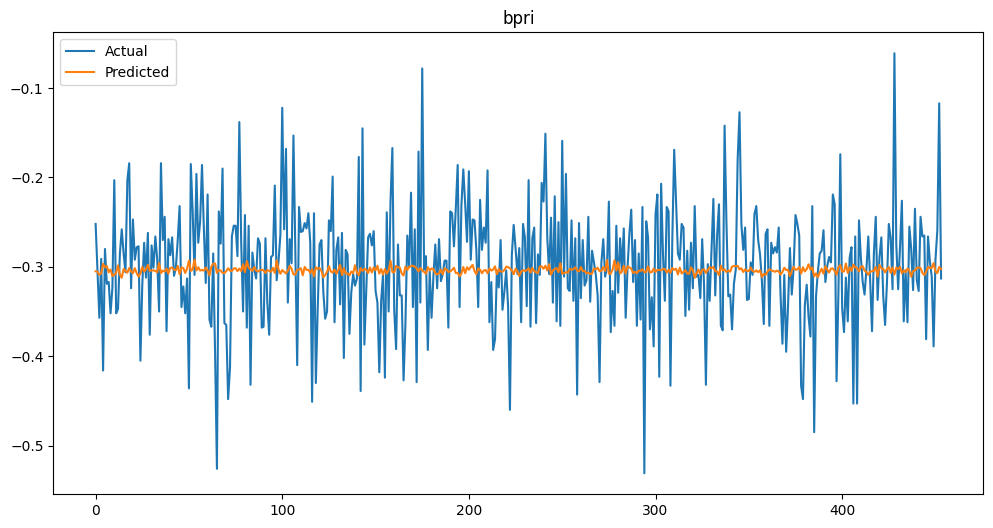

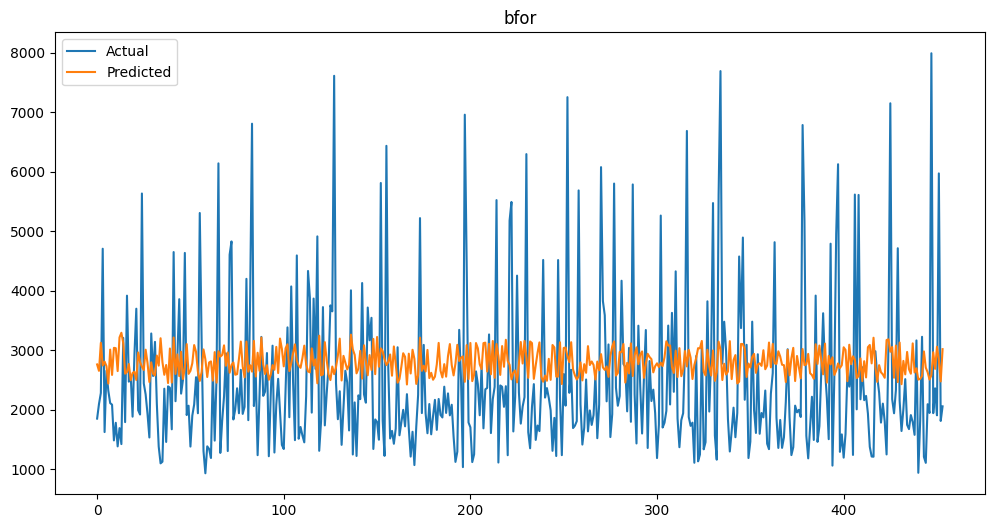

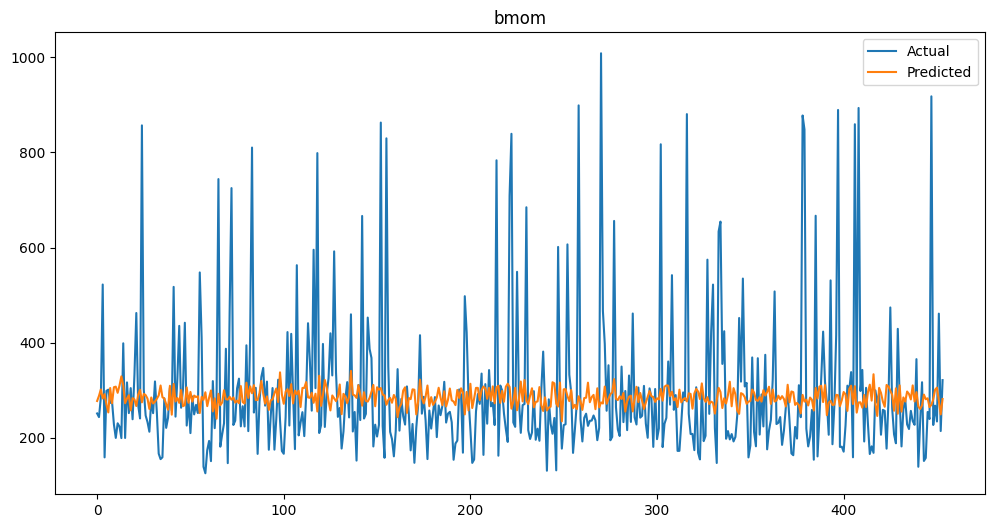

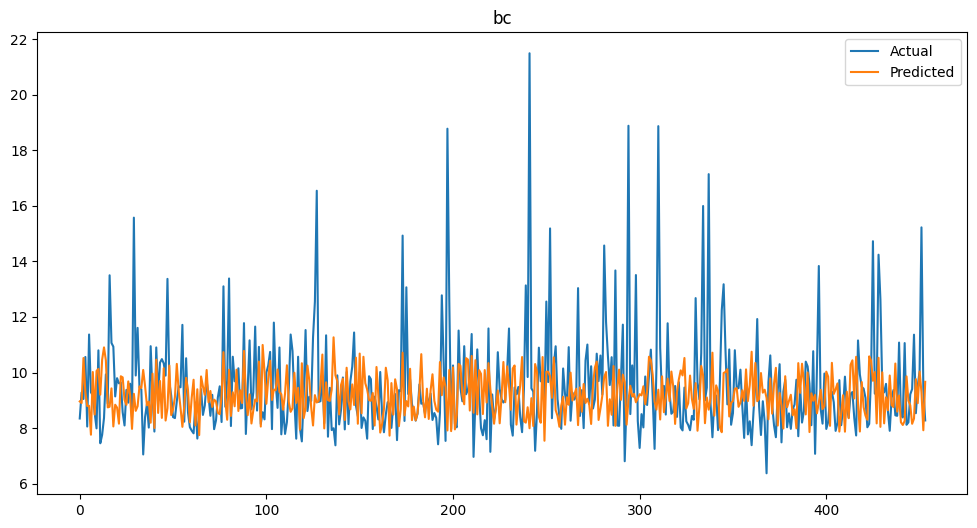

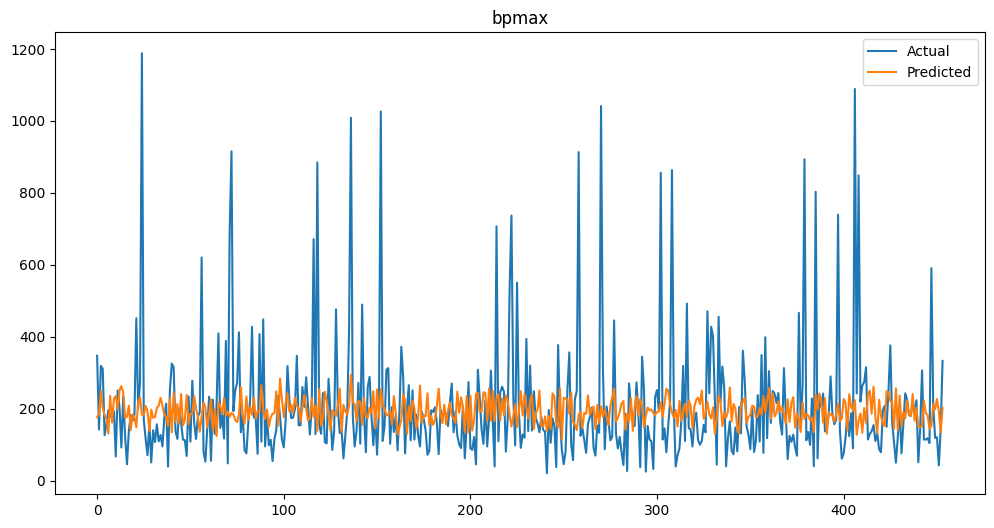

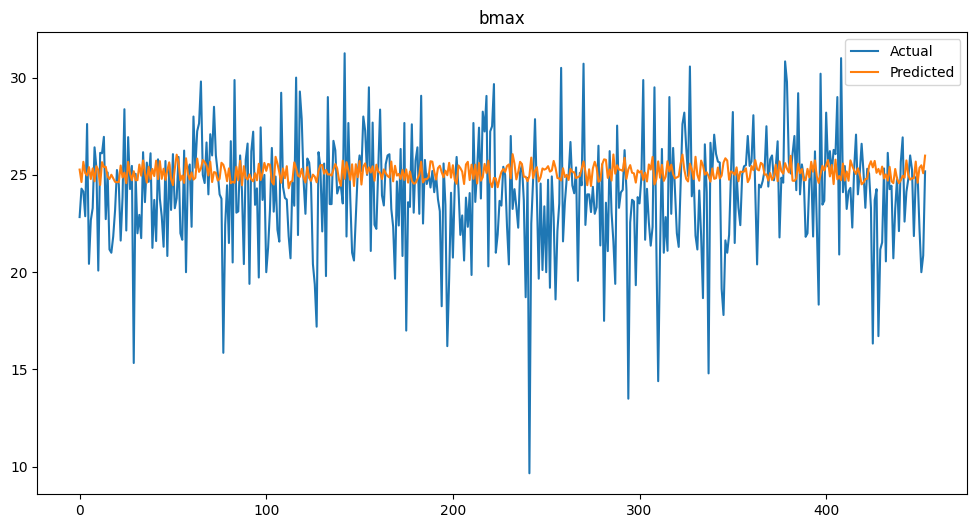

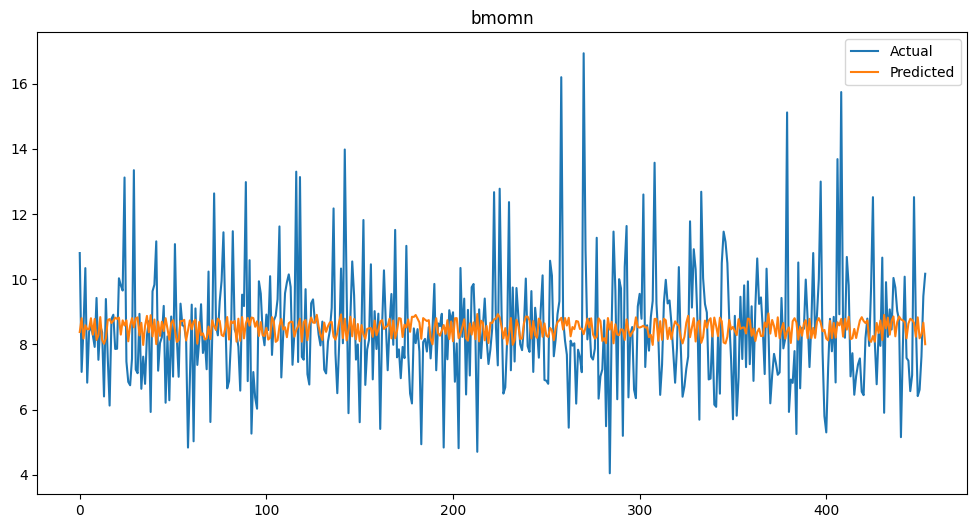

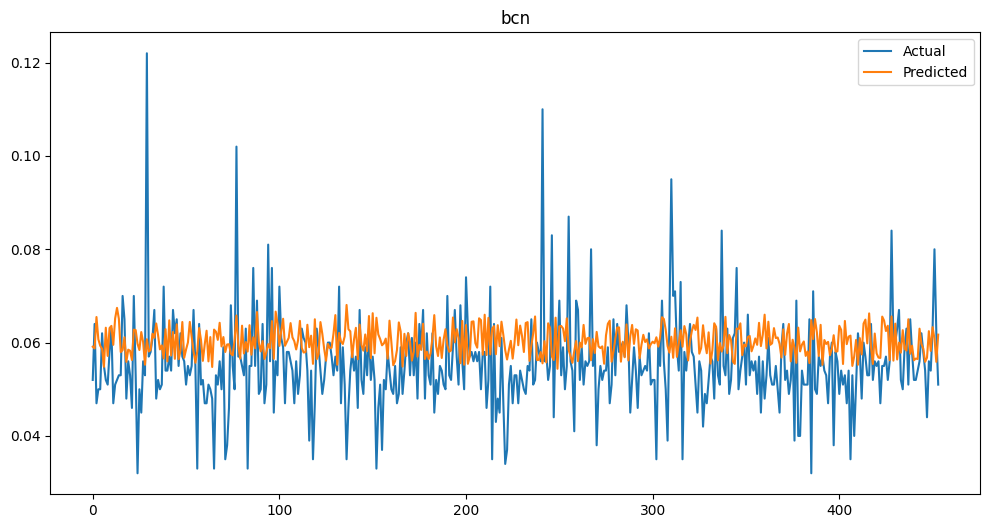

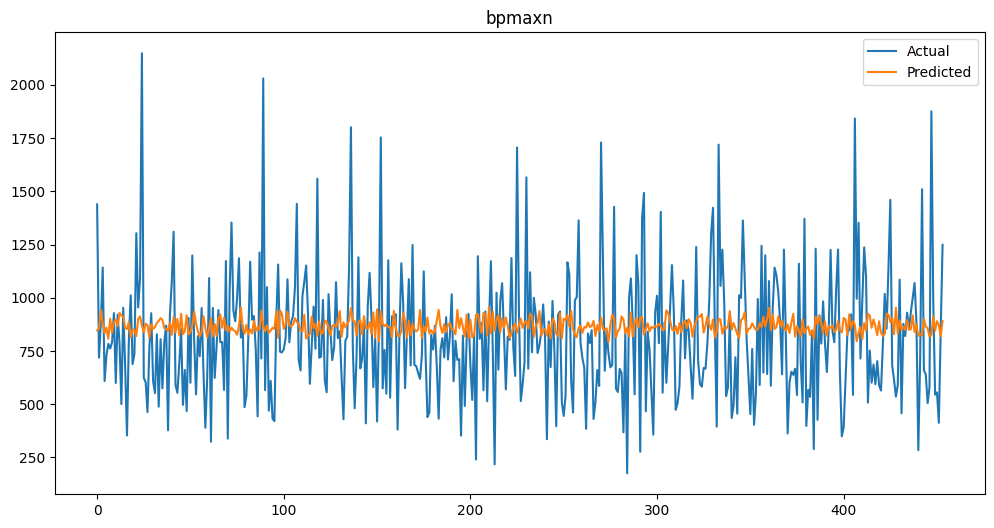

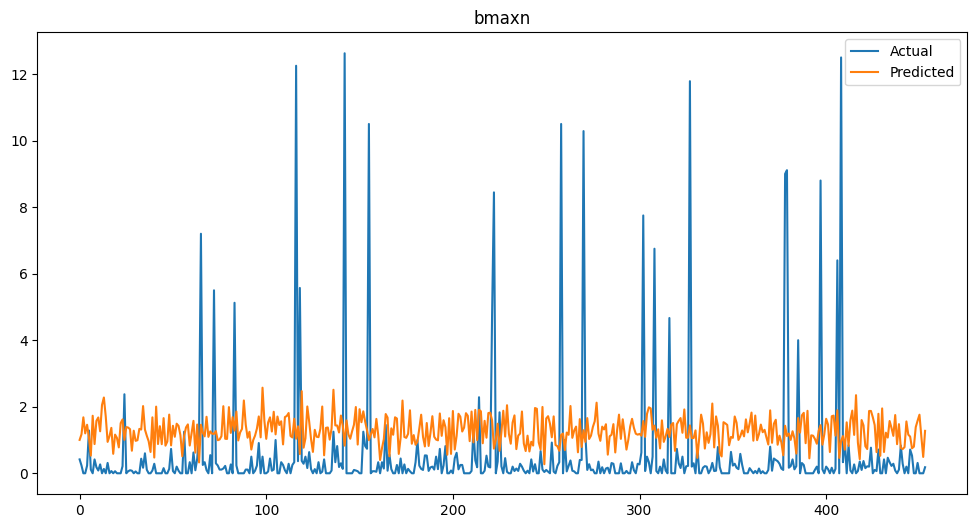

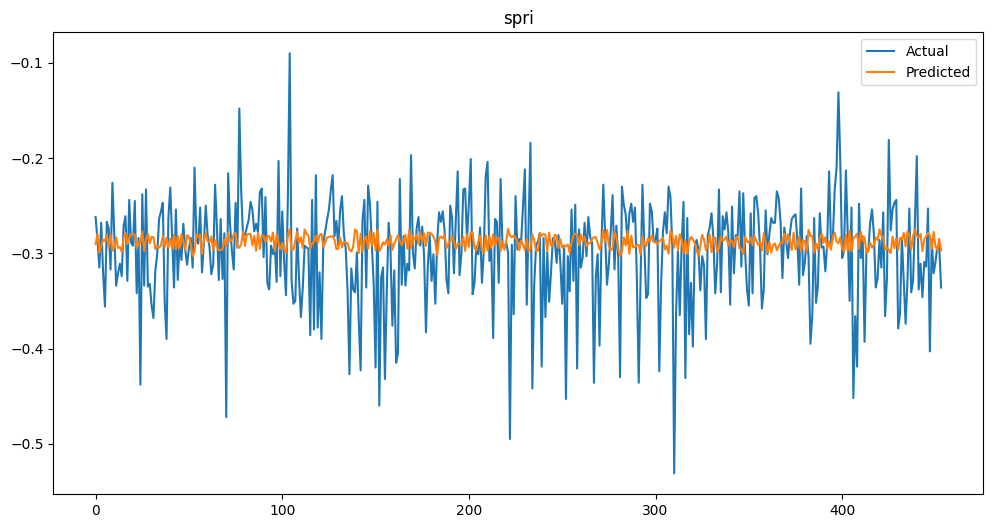

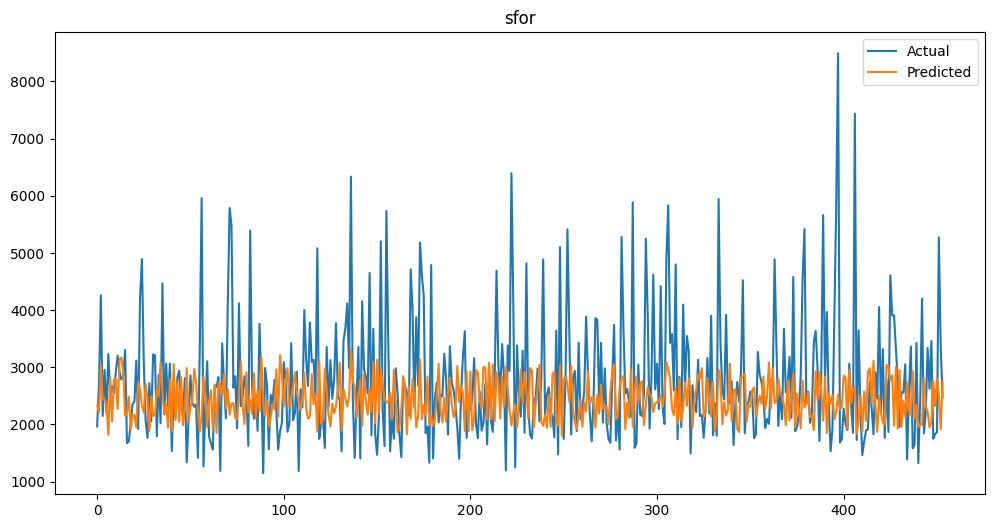

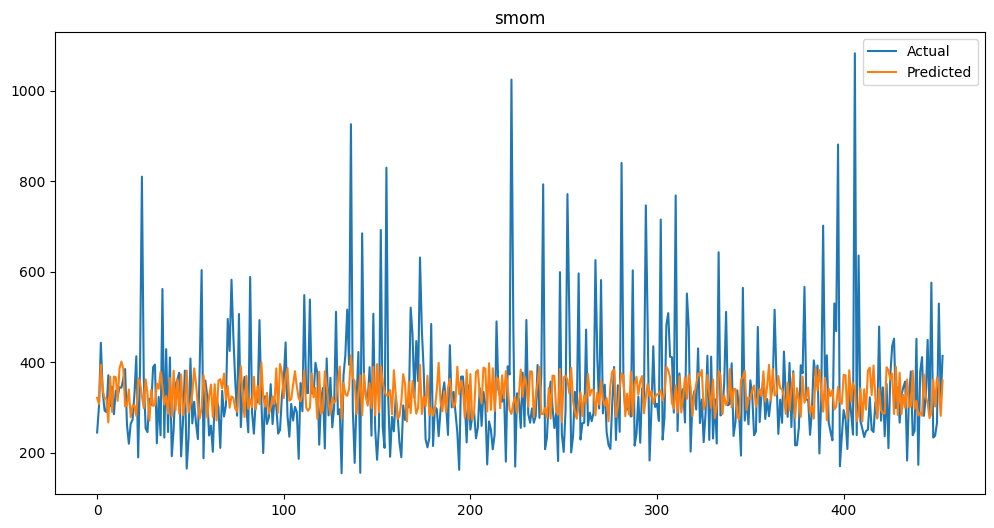

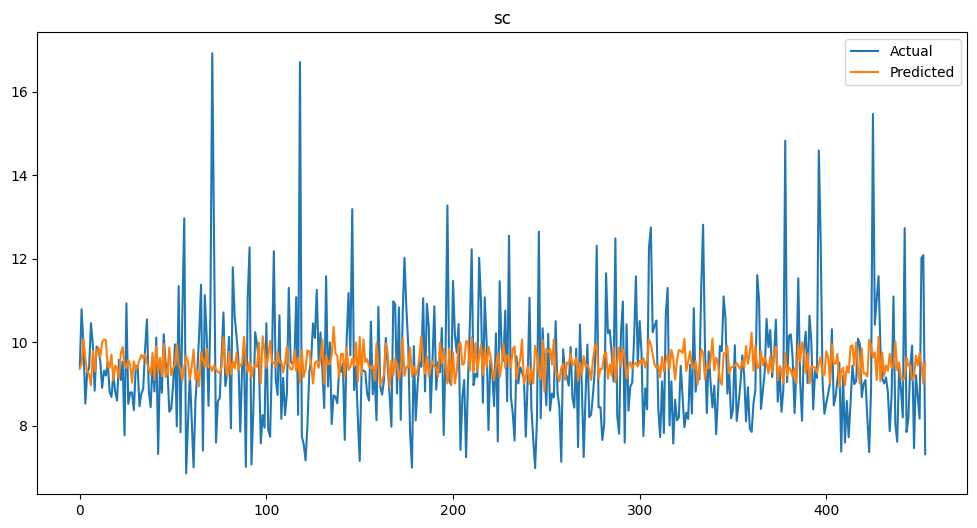

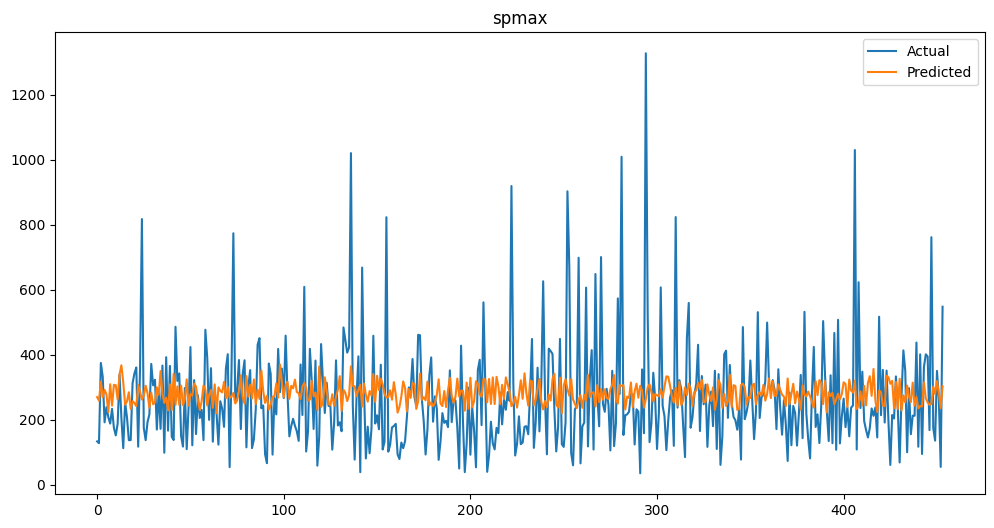

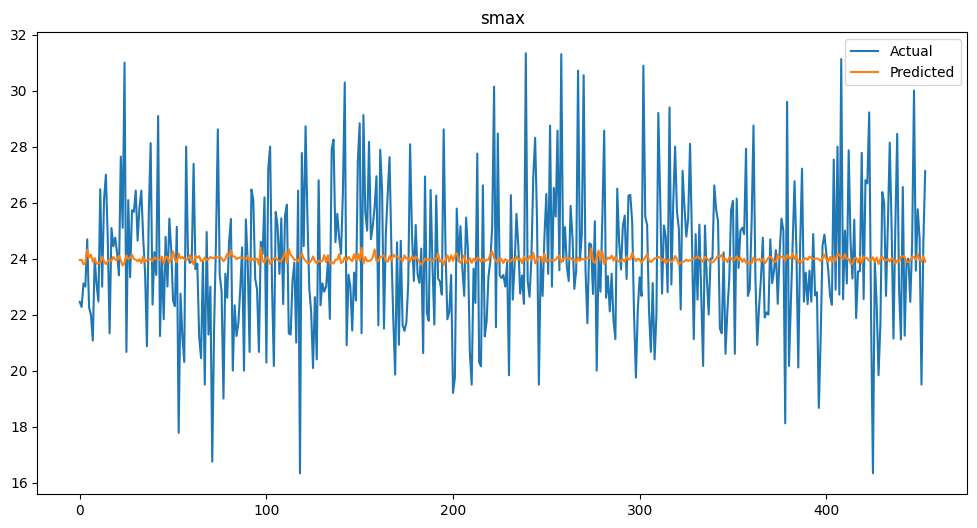

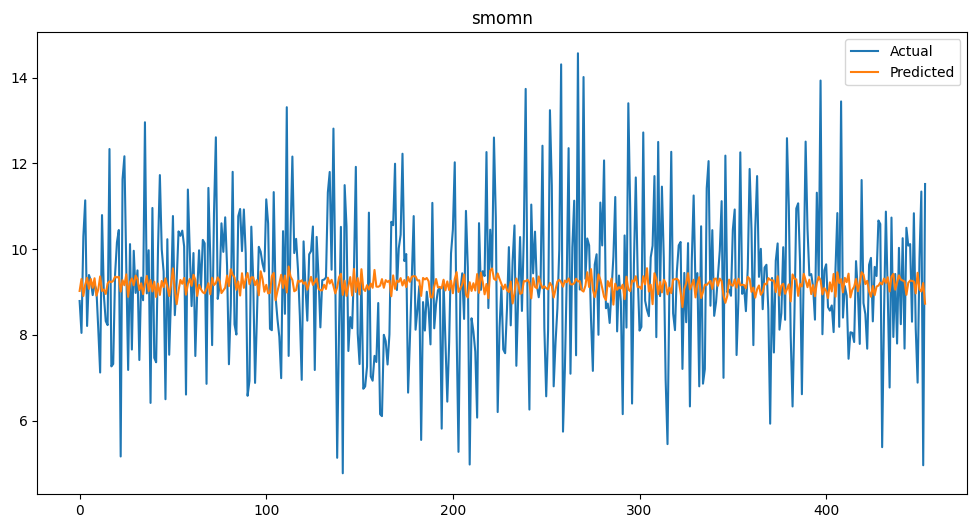

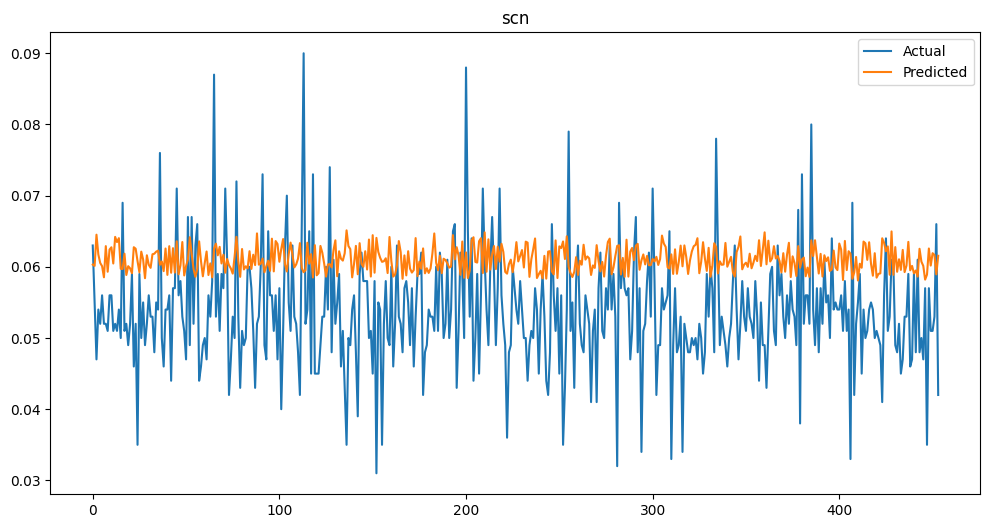

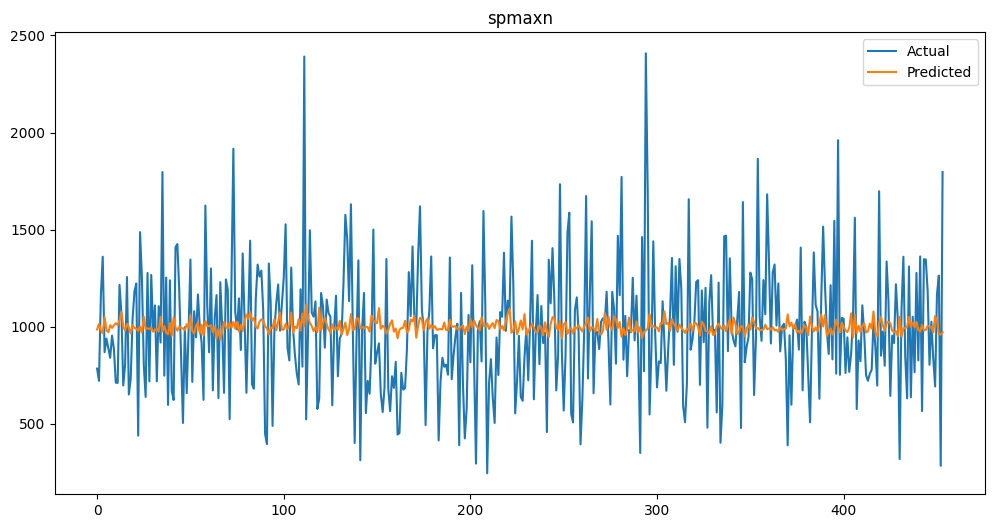

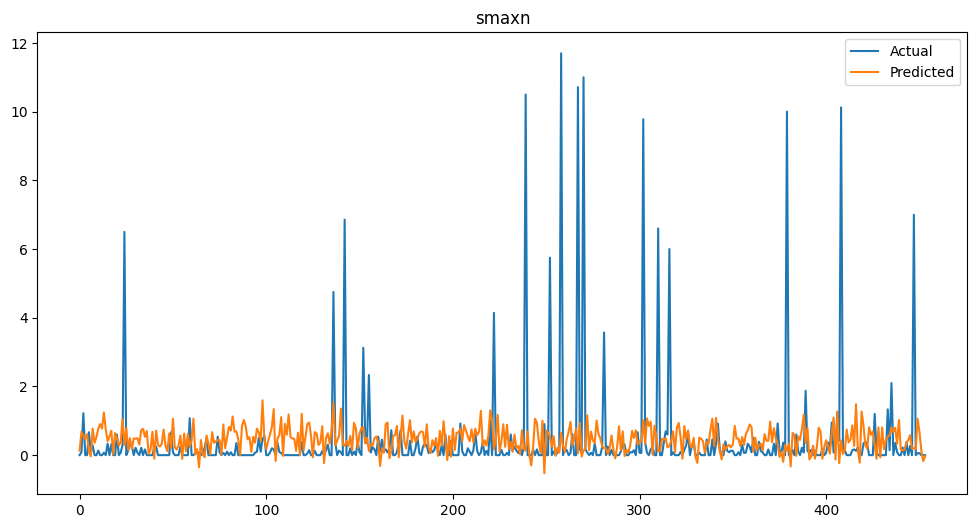

In [5]:

# 결과 저장 폴더가 없으면 생성
os.makedirs('result', exist_ok=True)

# 데이터 각각 시각화 및 저장
for i in range(1, len(header)):
    plt.figure(figsize=(12, 6))
    plt.plot(actual[:, i], label='Actual')
    plt.plot(predicted[:, i], label='Predicted')
    plt.title(header[i])
    plt.legend()
    plt.savefig(f'result/tcn_{header[i]}.png')
    plt.show()
    plt.close()  # 플롯을 닫아서 메모리 해제

torch.Size([454, 29]) torch.Size([454, 29])


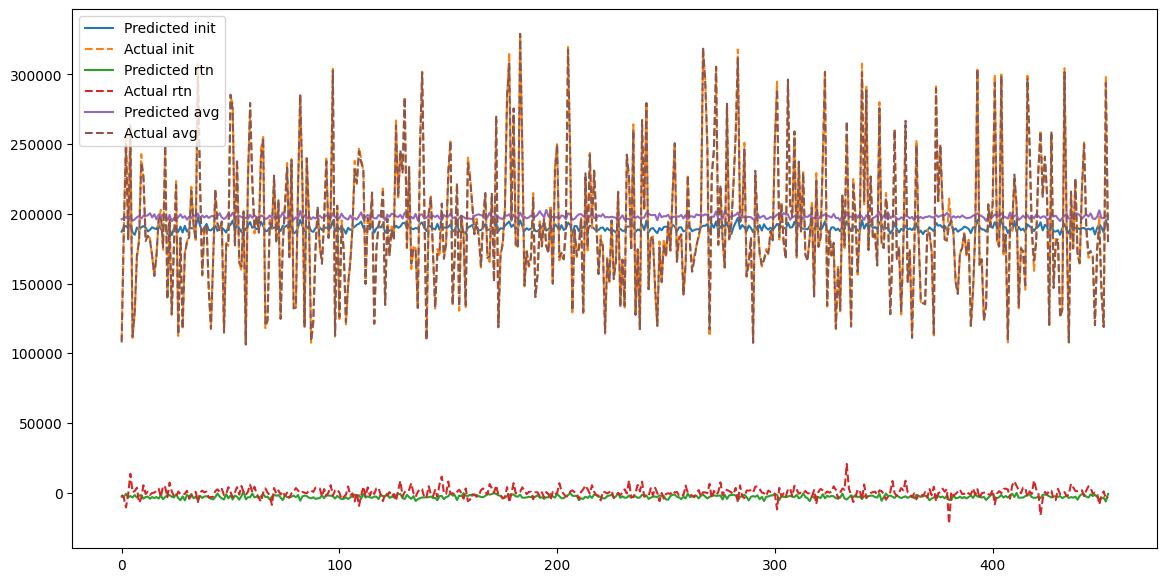

In [26]:
import numpy as np
print(test_outputs.shape, test_targets.shape)
# 예측 결과 시각화 및 저장
predicted = test_outputs.cpu().numpy()
actual = test_targets.cpu().numpy()

# 정규화 해제
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

# 헤더 정의
headers = "ymd	init	rtn	avg	dev	bkmax	skmax	bomega	somega	bpri	bfor	bmom	bc	bpmax	bmax	bmomn	bcn	bpmaxn	bmaxn	spri	sfor	smom	sc	spmax	smax	smomn	scn	spmaxn	smaxn".split("\t")

# 예측과 실제 값을 DataFrame으로 변환하여 저장
predicted_df = pd.DataFrame(predicted, columns=headers)
actual_df = pd.DataFrame(actual, columns=headers)

# 예측 결과 시각화 (예: 특정 열만 시각화)
plt.figure(figsize=(14, 7))
for col in ['init', 'rtn', 'avg']:  # 시각화할 열 선택
    plt.plot(predicted_df[col], label=f'Predicted {col}')
    plt.plot(actual_df[col], label=f'Actual {col}', linestyle='--')
plt.legend()
plt.show()

# 예측과 실제 값 DataFrame을 저장
predicted_df.to_csv("predicted_results.csv", index=False)
actual_df.to_csv("actual_results.csv", index=False)
